In [73]:
# Built-in modules
import os
import sys
import time
import statistics
from dataclasses import dataclass

# External modules
import scipy
import numpy as np
import pandas as pd
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bokeh.palettes import Pastel1
from tqdm import tqdm

# Local modules
from Window import Window
from Mapper import Mapper
import Trace
import PhaseDetector

In [100]:
TRACES = Trace.TraceList('parrot-traces/test-traces-2/', new_ext=True)

In [101]:
TRACES.load()

In [102]:
TRACES

2mm 2mm-mf

In [111]:
def summarize(arr, s):
    nint = len(arr) // s
    return [np.mean(arr[i*s : (i+1)*s]) for i in range(nint)]

def make_plot(ax, tr1, tr2, params):
    lat1 = summarize(tr1.data['latency_nano'], params.summarize)
    lat2 = summarize(tr2.data['latency_nano'], params.summarize)
    
    print(len(lat1))
    print(len(lat2))
    
    ax.plot(lat1, color='blue', label=tr1.name)
    ax.plot(lat2, color='black', label=tr2.name)
    
    ax.axvline(params.rr_start/params.summarize, color='red', label='RR')
    ax.axvline(params.rr_end/params.summarize, color='red')
    
    ax.set_xlabel(f"Inteval ({params.summarize}'s of instructions)")
    ax.set_ylabel(f"Mean Latency")
    
    
def super_plot(tr1, tr2, params):
    fig, ax = plt.subplots(constrained_layout=True)
    
    make_plot(ax, tr1, tr2, params)
    
    fig.legend()
    
    if params.savefig:
        fig.savefig('plots/2mm-mf-vs-normal-debug.png')

952
599


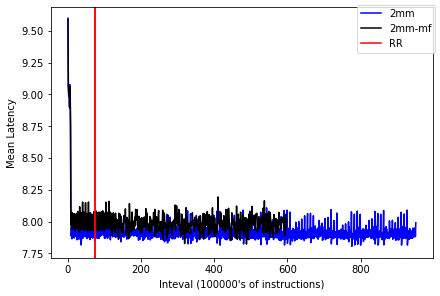

In [112]:
@dataclass(frozen=True)
class Param:
    summarize: int = 100_000
    savefig: bool = False
    rr_start: int = 7276500
    rr_end: int = rr_start+153000

super_plot(TRACES[0], TRACES[1], Param())

In [113]:
# Display the mean of the accesses contained in the RR
# We know the RR from the file for the mf run
# We know the RR from the optimizer for the normal run
# They are the same somehow? Incredible

def region_mean(trace, start, end):
    print(f'Mean [{trace.name}]:  \t{np.mean(trace.data["latency_nano"][start:end]):.3f}')

region_mean(TRACES[0], 1856000, 1856000+79000)
region_mean(TRACES[1], Param().rr_start,  Param().rr_end)



Mean m]:  	7.883
Mean m-mf]:  	7.985


Ok, so the mean is about right. 3.9. That's where the black line is above. Why aren't we getting the same behavior out of the MF model?

Our mean latency is too low. That should translate into an IPC that is too high. However, we are getting an IPC that is actually too low. 

That's not good. But let's focus on fixing the latency first.

In [84]:
import pickle
from simulate import *
with open('polybench-subset-mf-newparams-2mmonly.pkl', 'rb') as file:
    st_temp = pickle.load(file)

In [125]:
st_temp.st['2mm'].ipc

[0.562929007814645]

In [121]:

len(TRACES[1].data) / len(TRACES[0].data)

0.6289932483967193

In [126]:
95746218 / len(TRACES[0].data)

1.0047193980184534

In [127]:
 191446622/ len(TRACES[0].data)

2.0089580437371053

In [128]:
191446622/  199999999

0.9572331147861656

In [131]:
len(TRACES[0].data[TRACES[0].data['rwf']=='r'])

90497525

In [132]:
len(TRACES[0].data[TRACES[0].data['rwf']=='w'])

4798951

In [133]:
4798951/90497525

0.05302853310076712

In [135]:
import pickle
from simulate import *
with open('polybench-subset-normal.pkl', 'rb') as file:
    st_norm_temp = pickle.load(file)

In [137]:
st_norm_temp.st['2mm']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999           1493.532   
1            memHierarchy.Bus   62688352             99.152   
2          memHierarchy.Cache  294677250           2238.657   
3  memHierarchy.MemController   49999999            139.274   
4         memHierarchy.Parrot  144395094            363.888   

    avg. handler time (ns)  
0                     7467  
1                     1581  
2                     7596  
3                     2785  
4                     2520  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus     16102174           4.254                   264
1  memHierarchy.MemLink    206717178        1326.270                  6415
2   memHierarchy.Parrot    190592959         208.021                  1091
Simulated time:
  100.00 (+/-0.00) ms (sem 0.00)
Wallclock Time:
  Real: 6023500.00 (+/-0.00) ms (sem 0.0